In [4]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_io, utils_correlation, utils_plotting_correlation, utils_plotting
from lib_data import DATA_IO

In [5]:
PATH_CURR = os.path.abspath(os.curdir)    # current code
PATH      = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situated

# 1. LOAD DATASETS

## 1.1 Load LFP Data

In [8]:
# load LFP-PSD dataframe
LFP_PSD_controlateral = utils_io.load_LFP_event_PSD(event_category="tapping", event_laterality="controlateral")
LFP_PSD_ipsilateral   = utils_io.load_LFP_event_PSD(event_category="tapping", event_laterality="ipsilateral")

features              = ['event_no', 'pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean', 'pre_event_beta_high_mean', 'pre_event_gamma_mean', 
                         'event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean', 'event_beta_high_mean', 'event_gamma_mean',
                         'post_event_theta_mean', 'post_event_alpha_mean','post_event_beta_low_mean', 'post_event_beta_high_mean', 'post_event_gamma_mean']

for severity in LFP_PSD_controlateral.keys():
    LFP_PSD_controlateral[severity] = LFP_PSD_controlateral[severity][features]

LFP_PSD_controlateral = pd.concat([LFP_PSD_controlateral["noLID_noDOPA"],LFP_PSD_controlateral["noLID_DOPA"], LFP_PSD_controlateral["mild"], LFP_PSD_controlateral["moderate"]])
LFP_PSD_controlateral = LFP_PSD_controlateral.groupby('event_no').mean()
LFP_PSD_controlateral['event_no'] = LFP_PSD_controlateral.index
LFP_PSD_controlateral.reset_index(drop=True, inplace=True)

## 1.2 Load ECOG Data

In [22]:
ECOG_PSD_controlateral = utils_io.load_ECoG_event_PSD(event_category="tapping", event_laterality="controlateral")

In [16]:
# load ECOG-PSD dataframe
ECOG_PSD_controlateral = utils_io.load_ECoG_event_PSD(event_category="tapping", event_laterality="controlateral")
ECOG_PSD_ipsilateral   = utils_io.load_ECoG_event_PSD(event_category="tapping", event_laterality="ipsilateral")

features               = ['event_no', 'pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean', 'pre_event_beta_high_mean', 'pre_event_gamma_mean', 
                          'event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean', 'event_beta_high_mean', 'event_gamma_mean',
                          'post_event_theta_mean', 'post_event_alpha_mean','post_event_beta_low_mean', 'post_event_beta_high_mean', 'post_event_gamma_mean']

for severity in ECOG_PSD_controlateral.keys():
    ECOG_PSD_controlateral[severity] = ECOG_PSD_controlateral[severity][features]

ECOG_PSD_controlateral = pd.concat([ECOG_PSD_controlateral["noLID_noDOPA"],ECOG_PSD_controlateral["noLID_DOPA"], ECOG_PSD_controlateral["mild"], ECOG_PSD_controlateral["moderate"]])
ECOG_PSD_controlateral = ECOG_PSD_controlateral.groupby('event_no').mean()
ECOG_PSD_controlateral['event_no'] = ECOG_PSD_controlateral.index
ECOG_PSD_controlateral.reset_index(drop=True, inplace=True)

## 1.3 Load Accelerometer Data

In [13]:
def compute_normalized_sma(accelerometer, fs):

    duration                         = len(accelerometer) / fs
    signal_magnitude_area            = np.sum(accelerometer)
    signal_magnitude_area_normalized = signal_magnitude_area / duration
    
    return signal_magnitude_area_normalized

def compute_mean_crossing_rate(accelerometer, fs):
    
    mean_val      = np.mean(accelerometer)
    crossings     = np.diff(np.sign(accelerometer - mean_val)) != 0
    num_crossings = np.sum(crossings)
    
    # calculate duration in seconds
    duration = len(accelerometer) / fs
    
    # Normalize MCR by duration (crossings per second)
    mcr_normalized = num_crossings / duration
    
    return mcr_normalized

In [15]:
from EntropyHub import ApEn, SampEn


In [61]:
fs_ACC            = 512
df_ACCELEROMETER  = pd.read_pickle(DATA_IO.path_events + "ACCELEROMETER_RECORDINGS.pkl")
df_ACCELEROMETER  = df_ACCELEROMETER[(df_ACCELEROMETER.event_category=="tapping")]

tap_max    = []
tap_median = []
tap_mean   = []
tap_std    = []
tap_cv     = []
tap_sma    = []
tap_mcr    = []
tap_APEN   = []
tap_SAMEN  = []

for index, row in df_ACCELEROMETER.iterrows():
    
    tap_recording = row.event_onset_aligned[fs_ACC*2: (fs_ACC*2+(row.event_finish_index - row.event_start_index))]
    time          = np.linspace(0, (row.event_finish_index - row.event_start_index)/fs_ACC, len(tap_recording))

    # accelerometer features
    tap_max.append(np.max(tap_recording))
    tap_median.append(np.nanmedian(tap_recording))
    tap_mean.append(np.nanmean(tap_recording))
    tap_std.append(np.nanstd(tap_recording))
    tap_cv.append(np.nanstd(tap_recording)/np.nanmean(tap_recording))
    tap_sma.append(compute_normalized_sma(tap_recording, fs_ACC))
    tap_mcr.append(compute_mean_crossing_rate(tap_recording, fs_ACC))
    tap_APEN.append(ApEn(tap_recording, m=2)[0][0])
    tap_SAMEN.append(SampEn(tap_recording, m=2)[0][0])

df_ACCELEROMETER["tap_max"]    = tap_max
df_ACCELEROMETER["tap_median"] = tap_median
df_ACCELEROMETER["tap_mean"]   = tap_mean
df_ACCELEROMETER["tap_std"]    = tap_std
df_ACCELEROMETER["tap_cv"]     = tap_cv
df_ACCELEROMETER["tap_sma"]    = tap_sma
df_ACCELEROMETER["tap_mcr"]    = tap_mcr
df_ACCELEROMETER["tap_sample_etropy"]      = tap_SAMEN
df_ACCELEROMETER["tap_approximate_etropy"] = tap_APEN

df_ACCELEROMETER               = df_ACCELEROMETER[["patient","event_no","duration","dyskinesia_arm",
                                                   "tap_max","tap_median","tap_mean","tap_std","tap_cv","tap_sma","tap_mcr",
                                                   "tap_sample_etropy", "tap_approximate_etropy"]]

## 1.4 Merge Accelerometer and LFP Dataframe

In [91]:
ACC_LFP = pd.merge(df_ACCELEROMETER,LFP_PSD_controlateral,on='event_no', how='left')
ACC_LFP = ACC_LFP[ACC_LFP['pre_event_theta_mean'].notna()]
ACC_LFP.reset_index(drop=True, inplace=True)

## 1.5 Merge Accelerometer and ECOG Dataframe

In [94]:
ACC_ECOG = pd.merge(df_ACCELEROMETER, ECOG_PSD_controlateral,on='event_no', how='left')
ACC_ECOG = ACC_ECOG[ACC_ECOG['pre_event_theta_mean'].notna()]
ACC_ECOG.reset_index(drop=True, inplace=True)

# 2. Statistical Comparison of Dyskinesia Group for Tapping Standard Deviation

In [161]:
data                   = pd.DataFrame(ACC_LFP)
data['dyskinesia_arm'] = pd.Categorical(data['dyskinesia_arm'], categories=['none', 'mild', 'moderate'], ordered=True)

In [187]:
# Convert dyskinesia severity to a categorical variable
data['dyskinesia_arm'] = data['dyskinesia_arm'].astype('category')

# Fit the mixed-effects model

model_formula = "tap_mcr ~ dyskinesia_arm + pre_event_gamma_mean:dyskinesia_arm"
model         = sm.MixedLM.from_formula(model_formula, data=data, groups=data['patient'], re_formula = "~dyskinesia_arm")
result        = model.fit(method=["lbfgs"])


# Print the summary
print(result.summary())

                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               tap_mcr   
No. Observations:               2358                  Method:                           REML      
No. Groups:                     15                    Scale:                            20.6609   
Min. group size:                36                    Log-Likelihood:                   -6965.6776
Max. group size:                306                   Converged:                        Yes       
Mean group size:                157.2                                                             
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

<Figure size 640x480 with 0 Axes>

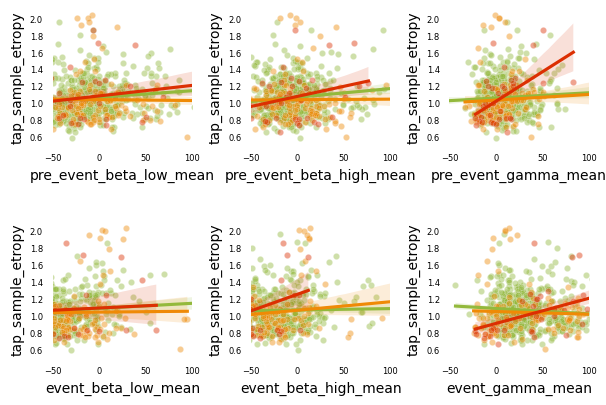

In [196]:
colors             = {}
colors["none"]     = utils_plotting.colors['no_LID']
colors["mild"]     = utils_plotting.colors["tapping"]["mild"]
colors["moderate"] = utils_plotting.colors["tapping"]["moderate"]

plt  = utils_plotting.get_figure_template()
ax1  = plt.subplot2grid((75, 40), (0, 0)  , colspan=10, rowspan=16)
ax2  = plt.subplot2grid((75, 40), (0, 14) , colspan=10, rowspan=16)
ax3  = plt.subplot2grid((75, 40), (0, 28)  , colspan=10, rowspan=16)
ax4  = plt.subplot2grid((75, 40), (25, 0) , colspan=10, rowspan=16)
ax5  = plt.subplot2grid((75, 40), (25, 14) , colspan=10, rowspan=16)
ax6  = plt.subplot2grid((75, 40), (25, 28) , colspan=10, rowspan=16)

feature = "pre_event_beta_low_mean"
for severity in ["none","mild","moderate"]:
    ax1  = utils_plotting_correlation.plot_correlation_line(ACC_ECOG, group_variable="dyskinesia_arm", group_value=severity, 
                                                            group_color=colors[severity], feat_x=feature, feat_y="tap_sample_etropy", scatter_size=20, ax=ax1)
feature = "pre_event_beta_high_mean"
for severity in ["none","mild","moderate"]:
    ax2  = utils_plotting_correlation.plot_correlation_line(ACC_ECOG, group_variable="dyskinesia_arm", group_value=severity, 
                                                            group_color=colors[severity], feat_x=feature, feat_y="tap_sample_etropy", scatter_size=20, ax=ax2)
feature = "pre_event_gamma_mean"
for severity in ["none","mild","moderate"]:
    ax3  = utils_plotting_correlation.plot_correlation_line(ACC_ECOG, group_variable="dyskinesia_arm", group_value=severity, 
                                                            group_color=colors[severity], feat_x=feature, feat_y="tap_sample_etropy", scatter_size=20, ax=ax3)
feature = "event_beta_low_mean"
for severity in ["none","mild","moderate"]:
    ax4  = utils_plotting_correlation.plot_correlation_line(ACC_ECOG, group_variable="dyskinesia_arm", group_value=severity, 
                                                            group_color=colors[severity], feat_x=feature, feat_y="tap_sample_etropy", scatter_size=20, ax=ax4) 
feature = "event_beta_high_mean"
for severity in ["none","mild","moderate"]:
    ax5  = utils_plotting_correlation.plot_correlation_line(ACC_ECOG, group_variable="dyskinesia_arm", group_value=severity, 
                                                            group_color=colors[severity], feat_x=feature, feat_y="tap_sample_etropy", scatter_size=20, ax=ax5)
feature = "event_gamma_mean"
for severity in ["none","mild","moderate"]:
    ax6  = utils_plotting_correlation.plot_correlation_line(ACC_ECOG, group_variable="dyskinesia_arm", group_value=severity, 
                                                            group_color=colors[severity], feat_x=feature, feat_y="tap_sample_etropy", scatter_size=20, ax=ax6)
ax1.set_xlim([-50,100])
ax2.set_xlim([-50,100])
ax3.set_xlim([-50,100])
ax4.set_xlim([-50,100])
ax5.set_xlim([-50,100])
ax6.set_xlim([-50,100])
#ax1.set_ylim([2e-7,1.2e-6])
#ax2.set_ylim([2e-7,1.2e-6])
#ax3.set_ylim([2e-7,1.2e-6])
#ax4.set_ylim([2e-7,1.2e-6])
#ax5.set_ylim([2e-7,1.2e-6])
#ax6.set_ylim([2e-7,1.2e-6])
plt.savefig(DATA_IO.path_figure + "correlation/sample entropy ECOG-ACC corr.svg", dpi=300)

In [181]:
features        = ['pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean', 'pre_event_beta_high_mean', 'pre_event_gamma_mean', 
                   'event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean', 'event_beta_high_mean', 'event_gamma_mean',
                   'post_event_theta_mean', 'post_event_alpha_mean', 'post_event_beta_low_mean', 'post_event_beta_high_mean','post_event_gamma_mean']

In [183]:
LFP_corr_spearman = utils_correlation.spearsman_correlation_with_multiple_comparison_correction(dataset=ACC_LFP, 
                                                                                                group_variable="dyskinesia_arm",
                                                                                                target_variable = "tap_sample_etropy", 
                                                                                                features=features, 
                                                                                                correction_type="holm")                                                                                  

mild : pre_event_theta_mean
mild : pre_event_alpha_mean
mild : pre_event_beta_low_mean
mild : pre_event_beta_high_mean
mild : pre_event_gamma_mean
mild : event_theta_mean
mild : event_alpha_mean
mild : event_beta_low_mean
mild : event_beta_high_mean
mild : event_gamma_mean
mild : post_event_theta_mean
mild : post_event_alpha_mean
mild : post_event_beta_low_mean
mild : post_event_beta_high_mean
mild : post_event_gamma_mean
moderate : pre_event_theta_mean
moderate : pre_event_alpha_mean
moderate : pre_event_beta_low_mean
moderate : pre_event_beta_high_mean
moderate : pre_event_gamma_mean
moderate : event_theta_mean
moderate : event_alpha_mean
moderate : event_beta_low_mean
moderate : event_beta_high_mean
moderate : event_gamma_mean
moderate : post_event_theta_mean
moderate : post_event_alpha_mean
moderate : post_event_beta_low_mean
moderate : post_event_beta_high_mean
moderate : post_event_gamma_mean
none : pre_event_theta_mean
none : pre_event_alpha_mean
none : pre_event_beta_low_mean
n

In [185]:
ECOG_corr_spearman = utils_correlation.spearsman_correlation_with_multiple_comparison_correction(dataset=ACC_ECOG, 
                                                                                                 group_variable="dyskinesia_arm",
                                                                                                 target_variable = "tap_sample_etropy", 
                                                                                                 features=features, 
                                                                                                 correction_type="holm")    

mild : pre_event_theta_mean
mild : pre_event_alpha_mean
mild : pre_event_beta_low_mean
mild : pre_event_beta_high_mean
mild : pre_event_gamma_mean
mild : event_theta_mean
mild : event_alpha_mean
mild : event_beta_low_mean
mild : event_beta_high_mean
mild : event_gamma_mean
mild : post_event_theta_mean
mild : post_event_alpha_mean
mild : post_event_beta_low_mean
mild : post_event_beta_high_mean
mild : post_event_gamma_mean
moderate : pre_event_theta_mean
moderate : pre_event_alpha_mean
moderate : pre_event_beta_low_mean
moderate : pre_event_beta_high_mean
moderate : pre_event_gamma_mean
moderate : event_theta_mean
moderate : event_alpha_mean
moderate : event_beta_low_mean
moderate : event_beta_high_mean
moderate : event_gamma_mean
moderate : post_event_theta_mean
moderate : post_event_alpha_mean
moderate : post_event_beta_low_mean
moderate : post_event_beta_high_mean
moderate : post_event_gamma_mean
none : pre_event_theta_mean
none : pre_event_alpha_mean
none : pre_event_beta_low_mean
n

In [198]:
LFP_corr_spearman[LFP_corr_spearman.pvalue_corrected<=0.05]

,group,feature,coefficient,pvalue,pvalue_corrected
0,mild,pre_event_theta_mean,0.134357,0.0008,0.0208
1,mild,pre_event_alpha_mean,0.219855,0.0002,0.0090
2,mild,pre_event_beta_low_mean,0.283403,0.0002,0.0090
3,mild,pre_event_beta_high_mean,0.404488,0.0002,0.0090
5,mild,event_theta_mean,0.201479,0.0002,0.0090
6,mild,event_alpha_mean,0.351179,0.0002,0.0090
7,mild,event_beta_low_mean,0.436236,0.0002,0.0090
8,mild,event_beta_high_mean,0.509062,0.0002,0.0090
9,mild,event_gamma_mean,-0.126286,0.0014,0.0308
12,mild,post_event_beta_low_mean,0.138226,0.0010,0.0230
